# torch.nn 究竟是什么？

译文：https://pytorch.apachecn.org/2.0/tutorials/beginner/nn_tutorial  
原文：https://pytorch.org/tutorials/beginner/nn_tutorial.html  

PyTorch 提供设计地很优雅的模块和类，比如 `torch.nn`, `torch.optim`, `Dataset` 和 `DataLoader` 来帮助你创建和训练神经网络。为了能完全发挥它们的能力并自定义它们来解决你的问题，你需要切实的理解它们在做什么。为了让你由浅入深的理解，我们会在 MNIST 数据集上首先训练基本的神经网络，暂时还不使用任何这些模型的特性；我们一开始只使用 PyTorch tensor 的最基本的功能。然后，我们会逐渐地从这些特性中每次增加一个，展示每一样究竟做了什么，以及它是如何让代码更加准确或者更加灵活的。

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)
    print('Downloaded', FILENAME)

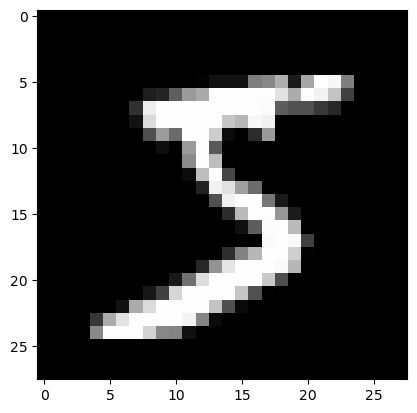

x_train.shape = (50000, 784)
torch.Size([50000, 784])
tensor(0) tensor(9)


In [4]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

from matplotlib import pyplot
import numpy as np

# 展示第一张图像
pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
pyplot.show()

print('x_train.shape =', x_train.shape)

# 转换为 torch tensors
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

n, c = x_train.shape
print(x_train.shape)
print(y_train.min(), y_train.max())

## 神经网络从零开始（不用 torch.nn）

让我们首先只用 PyTorch tensor 操作来创建一个模型。PyTorch 提供创建填充了随机数或者零的 tensor 的方法，我们将用这些方法来创建一个简单线性模型的权重和偏差。它们只是普通的 tensor，但我们会设置 `requires_grad=True` 以便自动求导。注意：我们用 Xavier 初始化（乘以 1/sqrt(n)）。

In [5]:
import math

# 初始化权重与偏置（Xavier 初始化），并启用梯度
a = 784
b = 10
weights = torch.randn(a, b) / math.sqrt(a)
weights.requires_grad_()
bias = torch.zeros(b, requires_grad=True)

# log_softmax 与模型定义
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [6]:
bs = 64  # 批大小
xb = x_train[0:bs]
preds = model(xb)
print(preds[0], preds.shape)

tensor([-2.3001, -2.2555, -2.5420, -2.5625, -2.4213, -2.4842, -2.3358, -1.8887,
        -2.2915, -2.1388], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [7]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

yb = y_train[0:bs]
print(loss_func(preds, yb))

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

print(accuracy(preds, yb))

tensor(2.3109, grad_fn=<NegBackward0>)
tensor(0.0938)


In [8]:
from IPython.core.debugger import set_trace

lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        # set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0829, grad_fn=<NegBackward0>) tensor(1.)


## 使用 torch.nn.functional

将手写的激活与损失函数替换为 `torch.nn.functional` 中的实现。使用 `F.cross_entropy`（内部包含 `log_softmax` + NLL）。

In [9]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0829, grad_fn=<NllLossBackward0>) tensor(1.)


## 用 nn.Module 重构

子类化 `nn.Module` 与 `nn.Parameter`，将权重与偏置作为模型状态管理；使用 `forward` 定义前向计算。

In [10]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

model = Mnist_Logistic()
print(loss_func(model(xb), yb))

# 使用 model.parameters() 和 model.zero_grad() 的训练循环
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()
print(loss_func(model(xb), yb))

tensor(2.2790, grad_fn=<NllLossBackward0>)
tensor(0.0830, grad_fn=<NllLossBackward0>)
tensor(0.0830, grad_fn=<NllLossBackward0>)


## 用 nn.Linear 重构

使用 `nn.Linear(784, 10)` 替代手动权重与偏置定义，前向直接调用线性层。

In [11]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
    def forward(self, xb):
        return self.lin(xb)

model = Mnist_Logistic()
print(loss_func(model(xb), yb))

fit()
print(loss_func(model(xb), yb))

tensor(2.3267, grad_fn=<NllLossBackward0>)
tensor(0.0802, grad_fn=<NllLossBackward0>)
tensor(0.0802, grad_fn=<NllLossBackward0>)


## 用 torch.optim 重构

使用 `optim.SGD` 的 `step()` 和 `zero_grad()` 替代手动参数更新。

In [12]:
from torch import optim

lr = 0.5  # 复用前面的学习率
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3142, grad_fn=<NllLossBackward0>)
tensor(0.0822, grad_fn=<NllLossBackward0>)
tensor(0.0822, grad_fn=<NllLossBackward0>)


## 用 Dataset 重构

使用 `TensorDataset` 将 `x_train` 与 `y_train` 封装到一个数据集，便于按批索引与切片。

In [13]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)

model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs : i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0829, grad_fn=<NllLossBackward0>)


## 用 DataLoader 重构

`DataLoader` 能从任意 `Dataset` 生成按批迭代的数据流，自动产出 `(xb, yb)`。

In [14]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0808, grad_fn=<NllLossBackward0>)


## 增加验证

创建训练与验证集的 DataLoader，训练阶段 `model.train()`，评估阶段 `model.eval()` 并汇总验证损失。

In [15]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.2955)
1 tensor(0.3166)
1 tensor(0.3166)


## 创建 fit() 与 get_data()

将每批的损失计算封装为 `loss_batch`，并实现通用的 `fit` 训练循环与 `get_data` 数据加载器构造函数。

In [16]:
import numpy as np

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(xb)


def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        model.eval()
        with torch.no_grad():
            losses, nums = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl])
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print(epoch, val_loss)


def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.316369152033329
1 0.28831297622919083
1 0.28831297622919083


## 换成 CNN

定义 3 层卷积的 CNN，并沿用通用训练循环进行训练与验证。

In [17]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3545902111530304
1 0.2335419843196869
1 0.2335419843196869


## 使用 nn.Sequential

用 `nn.Sequential` 简化模型结构，配合自定义 `Lambda` 层处理 `view` 等操作。

In [18]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, x):
        return self.func(x)

def preprocess(x):
    return x.view(-1, 1, 28, 28)

model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.371336292052269
1 0.22604868812561035
1 0.22604868812561035


## 包装 DataLoader 与自适应池化

用 `WrappedDataLoader` 将预处理放在迭代过程中；用 `nn.AdaptiveAvgPool2d(1)` 适配任意输入尺寸。

In [19]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
    def __len__(self):
        return len(self.dl)
    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))

train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3499101365327835
1 0.26811726083755494
1 0.26811726083755494


## 使用你的 GPU

检查 CUDA 可用性，创建设备 `dev`，将数据与模型移动到 GPU（若可用）并训练。

In [20]:
print(torch.cuda.is_available())

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

model = model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

True
0 0.2232966646194458
0 0.2232966646194458
1 0.18697779413461685
1 0.18697779413461685


## 总结与后续

本笔记从零开始搭建 MNIST 分类器，一步步过渡到更高层的 PyTorch API：

- 手写 `log_softmax` 与 NLL 损失，理解梯度下降细节；
- 使用 `torch.nn.functional` 简化损失与激活；
- 封装为 `nn.Module` 与 `nn.Linear`，通过 `parameters()` 统一管理权重；
- 借助 `torch.optim` 优化器，规范化训练循环；
- 用 `TensorDataset`/`DataLoader` 管理数据与批次；
- 抽象 `fit`/`loss_batch`/`get_data`，形成通用训练范式；
- 构建卷积网络与 `nn.Sequential`/自定义 `Lambda` 层；
- 使用 `WrappedDataLoader` 与 `AdaptiveAvgPool2d` 简化预处理与尺寸变化；
- 在可用时将模型与数据迁移到 GPU 加速训练。

可以尝试：

- 调整 `bs/epochs/lr/momentum` 等超参；
- 将优化器替换为 `Adam` 等；
- 在 CNN 中加入 `BatchNorm`/`Dropout`；
- 扩展到 CIFAR-10/自定义数据集。